### Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
import collections

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.metrics import mean_squared_error, mean_absolute_error

import category_encoders as ce

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

from sklearn.compose import TransformedTargetRegressor

### Import drive, dataset, helper functions

In [20]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parents[1]))
from Helper_Functions import common_utils

2022-07-14 10:22:12.798118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-14 10:22:12.798149: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parents[1]))
from Helper_Functions import common_utils
directory_to_extract_to = os.getcwd()

common_utils.load_data_from_one_drive(directory_to_extract_to, "regression_paths", "us_car_dataset_path")

Done!


### Import and read data

In [73]:
df= pd.read_csv('USA_cars_datasets.csv')

In [74]:
df.head()

,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


In [75]:
df.columns

Index(['Unnamed: 0', 'price', 'brand', 'model', 'year', 'title_status',
       'mileage', 'color', 'vin', 'lot', 'state', 'country', 'condition'],
      dtype='object')

In [76]:
df.dtypes

Unnamed: 0        int64
price             int64
brand            object
model            object
year              int64
title_status     object
mileage         float64
color            object
vin              object
lot               int64
state            object
country          object
condition        object
dtype: object

In [21]:
common_utils.get_dataset_info(df)

Head:
   price      brand    model  year   title_status   mileage   color  \
0   6300     toyota  cruiser  2008  clean vehicle  274117.0   black   
1   2899       ford       se  2011  clean vehicle  190552.0  silver   
2   5350      dodge      mpv  2018  clean vehicle   39590.0  silver   
3  25000       ford     door  2014  clean vehicle   64146.0    blue   
4  27700  chevrolet     1500  2018  clean vehicle    6654.0     red   

        state country      condition  
0  new jersey     usa   10 days left  
1   tennessee     usa    6 days left  
2     georgia     usa    2 days left  
3    virginia     usa  22 hours left  
4     florida     usa  22 hours left  
Shape: (2499, 10)


In [77]:
# Delete columns : 'vin','lot','Unnamed: 0'
# We are dropping these columns, because they do not contain any datathat is useful for prediction
df = df.drop(columns = ['vin','lot','Unnamed: 0'])

In [78]:
common_utils.get_count_and_percentage_missing_values(df)

              count  % null
price             0     0.0
brand             0     0.0
model             0     0.0
year              0     0.0
title_status      0     0.0
mileage           0     0.0
color             0     0.0
state             0     0.0
country           0     0.0
condition         0     0.0


### Data preprocessing

#### Duplicates

In [23]:
def remove_duplicates(df):
  return df.drop_duplicates()

#### Process condition colum

In [22]:
# #Explore column condition
df.condition.value_counts()

2 days left        832
21 hours left      492
3 days left        137
14 hours left      108
1 days left         91
8 days left         82
17 hours left       76
20 hours left       67
9 days left         58
22 hours left       57
6 days left         52
18 hours left       48
19 hours left       45
7 days left         43
11 days left        42
16 hours left       36
2 hours left        26
10 days left        23
Listing Expired     20
29 minutes          18
23 hours left       16
4 days left         16
5 hours left        16
1 minutes           15
6 hours left        12
24 hours left        9
12 days left         8
15 hours left        8
34 minutes           7
7 hours left         7
5 days left          6
15 days left         4
1 hours left         3
9 minutes            3
48 minutes           2
3 hours left         2
47 minutes           2
13 days left         1
16 minutes           1
53 minutes           1
27 minutes           1
30 minutes           1
32 minutes           1
28 minutes 

In [24]:
def remove_canada(df):
  df.drop(df.loc[df['country']== 'canada'].index, inplace=True) #deleting rows where 'country' = canada
  return df

In [25]:
def remove_country(df):
  df = df.drop(columns = ['country'])
  return df

In [26]:
def remove_listing_expired(df):
  df.drop(df.loc[df['condition']== 'Listing Expired'].index, inplace=True) #deleting rows where 'condition' = Listing Expired
  return df

In [27]:
#Convert condition from string to int in minutes
def convert_condition(df):
  conditions=[]
  for i, row in tqdm.tqdm(df.iterrows()): #loop through rows
      temp = df['condition'][i].split() #spliting strings
      label = temp[1].rstrip() #selecting second value in a string
      row_new = -1
      
      # transform string to int
      if 'day' in label:
          row_new = int(temp[0].rstrip()) * int(24 * 60) #Convert days to minutes
      elif 'minute' in label:
          row_new = int(temp[0].rstrip()) * int(1) #keep minutes as it is
      elif 'hour' in label:
          row_new = int(temp[0].rstrip()) * int(60) #Convert hours to minutes
      
      conditions.append(row_new) # store numeric values into a list
      
  df['condition_new'] = conditions #creating new column with transformed 'condition'
  return df

In [28]:
def remove_condition(df):
  df = df.drop(columns = ['condition'])
  return df

In [79]:
df.head()

,price,brand,model,year,title_status,mileage,color,state,country,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552.0,silver,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,florida,usa,22 hours left


#### Heatmap

In [81]:
common_utils.plot_heatmap(df_new)

                        price      year   mileage  condition_new  brand_audi  \
price                1.000000  0.419696 -0.401143       0.006129   -0.015759   
year                 0.419696  1.000000 -0.594460      -0.014138   -0.063586   
mileage             -0.401143 -0.594460  1.000000      -0.042289    0.044140   
condition_new        0.006129 -0.014138 -0.042289       1.000000   -0.010666   
brand_audi          -0.015759 -0.063586  0.044140      -0.010666    1.000000   
...                       ...       ...       ...            ...         ...   
state_washington     0.050434 -0.001491  0.003300      -0.023163   -0.003030   
state_west virginia -0.024986 -0.027962  0.016963      -0.016753   -0.003716   
state_wisconsin      0.039491 -0.067806  0.013877      -0.077602    0.044639   
state_wyoming       -0.031178 -0.073956 -0.017565      -0.012226   -0.000808   
country_ usa        -0.051443 -0.033074  0.005748      -0.160735    0.002139   

                     brand_bmw  brand_b

KeyboardInterrupt: 

#### Using select k best feature to get which columns to use

In [29]:
# x_num = df[['year', 'condition_new', 'mileage']]
# y = df['price']

In [30]:
# from sklearn.feature_selection import SelectKBest, chi2, f_regression
# selector1 = SelectKBest(score_func = f_regression, k = 2)
# selector1.fit(x_num, y)

In [31]:
# cols = selector1.get_support(indices=True)

In [32]:
# cols

From here, it is evident that condition_new column has least corelation with price

In [30]:
def remove_condition_new(df):
  df = df.drop(columns = ['condition_new'])
  return df

#### Getting a trend of categorical data

In [31]:
df.title_status.value_counts()

clean vehicle        2336
salvage insurance     163
Name: title_status, dtype: int64

In [35]:
df.color.value_counts()

white                                      707
black                                      516
gray                                       395
silver                                     300
red                                        192
blue                                       151
no_color                                    61
green                                       24
orange                                      20
gold                                        19
charcoal                                    18
brown                                       15
yellow                                       9
magnetic metallic                            6
shadow black                                 5
color:                                       5
beige                                        5
oxford white                                 4
ingot silver metallic                        4
super black                                  3
billet silver metallic clearcoat             3
triple yellow

In [32]:
df.brand.value_counts()

ford               1235
dodge               432
nissan              312
chevrolet           297
gmc                  42
jeep                 30
chrysler             18
bmw                  17
hyundai              15
kia                  13
buick                13
infiniti             12
honda                12
cadillac             10
mercedes-benz        10
heartland             5
land                  4
peterbilt             4
audi                  4
acura                 3
lincoln               2
lexus                 2
mazda                 2
maserati              1
toyota                1
harley-davidson       1
jaguar                1
ram                   1
Name: brand, dtype: int64

In [37]:
df.model.value_counts()

door        651
f-150       219
doors       148
caravan     102
mpv          87
           ... 
sl-class      1
cx-3          1
2500hd        1
mdx           1
nvp           1
Name: model, Length: 127, dtype: int64

#### Combining brand and model

In [33]:
def combine_brand_model(df):
  df["brand_model"] = df["brand"].astype(str) + " " + df["model"].astype(str)
  df = df.drop(columns = ['brand', 'model'])
  return df

#### Combining country and state

In [34]:
def combine_country_state(df):
  df['location'] = df["country"].astype(str) + " " + df["state"].astype(str)
  df = df.drop(columns = ['country', 'state'])
  return df

#### Removing outliers

In [35]:
def remove_outlier(df, col_name):
  q1 = df[col_name].quantile(0.25)
  q3 = df[col_name].quantile(0.75)
  iqr = q3-q1 #Interquartile range
  fence_low  = q1-2*iqr
  fence_high = q3+2*iqr
  df_out = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
  return df_out

#### Encoding

In [36]:
def apply_encoding(df, columns, be=True):
  #Applying one hot encoding on title_status
  df_one = pd.get_dummies(df['title_status'])
  df_two = pd.concat((df_one, df), axis=1)
  df_two = df_two.drop(["title_status"], axis=1)
  df_two = df_two.drop(["salvage insurance"], axis=1)
  df = df_two.rename(columns={"clean vehicle": "title_status"})

  if be == True :
    #Applying binary encoding to color, brand_model. location
    encoder= ce.BinaryEncoder(cols=columns,return_df=True)
    df=encoder.fit_transform(df) 
  else:
    label_encoder = LabelEncoder()
    for col in columns:
      df[col]= label_encoder.fit_transform(df[col])
  return df

##### One hot encoding

#### Count of outliers using Isolation Forest 

In [37]:
# check_outlier_year = IsolationForest(random_state=0).fit(df_train['year'].to_numpy().reshape(-1, 1))
# outliers_year = check_outlier_year.predict(df_train['year'].to_numpy().reshape(-1, 1))
# collections.Counter(outliers_year)

In [38]:
# check_outlier_mileage = IsolationForest(random_state=0).fit(df_train['mileage'].to_numpy().reshape(-1, 1))
# outliers_mileage = check_outlier_mileage.predict(df_train['mileage'].to_numpy().reshape(-1, 1))
# collections.Counter(outliers_mileage)

#### Count of outliers using LocalOutlierFactor

In [39]:
# outliers_year = LocalOutlierFactor(n_neighbors = 5).fit_predict(df_train['year'].to_numpy().reshape(-1, 1))
# collections.Counter(outliers_year)

In [40]:
# outliers_mileage = LocalOutlierFactor(n_neighbors = 5).fit_predict(df_train['mileage'].to_numpy().reshape(-1, 1))
# collections.Counter(outliers_mileage)

### XGBOOST

#### One hot encoding

In [41]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [80]:
df_new = remove_duplicates(df)
df_new = remove_listing_expired(df_new)
df_new = convert_condition(df_new)
df_new = remove_condition(df_new)

df_new = create_dummy_df(df_new,['brand', 'model', 'title_status', 'color', 'state', 'country',],dummy_na=False)
df_new.head()

2479it [00:00, 13075.65it/s]


,price,year,mileage,condition_new,brand_audi,brand_bmw,brand_buick,brand_cadillac,brand_chevrolet,brand_chrysler,...,state_tennessee,state_texas,state_utah,state_vermont,state_virginia,state_washington,state_west virginia,state_wisconsin,state_wyoming,country_ usa
0,6300,2008,274117.0,14400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2899,2011,190552.0,8640,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,5350,2018,39590.0,2880,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,25000,2014,64146.0,1320,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,27700,2018,6654.0,1320,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
df_new_train, df_new_test = train_test_split(df_new, test_size = .30, random_state=1)

In [44]:
print(df_new_train.shape, df_new_test.shape)

(1735, 250) (744, 250)


In [45]:
df_new_train = remove_outlier(df_new_train, 'condition_new')
df_new_test = remove_outlier(df_new_test, 'condition_new')

In [46]:
df_new_train = remove_outlier(df_new_train, 'mileage')
df_new_test = remove_outlier(df_new_test, 'mileage')

In [47]:
df_new_train = remove_outlier(df_new_train, 'year')
df_new_test = remove_outlier(df_new_test, 'year')

In [48]:
print(df_new_train.shape, df_new_test.shape)

(1409, 250) (578, 250)


In [49]:
x_train = df_new_train.copy()
x_train = x_train.drop(columns = ['price'])
y_train = df_new_train['price']

In [50]:
x_test = df_new_test.copy()
x_test = x_test.drop(columns = ['price'])
y_test = df_new_test['price']

In [51]:
# define model
model = XGBRegressor(learning_rate = 0.01, n_estimators = 1000, max_depth = 10)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [52]:
y_hat = model.predict(x_test)

In [53]:
y_test_arr = y_test.to_numpy()

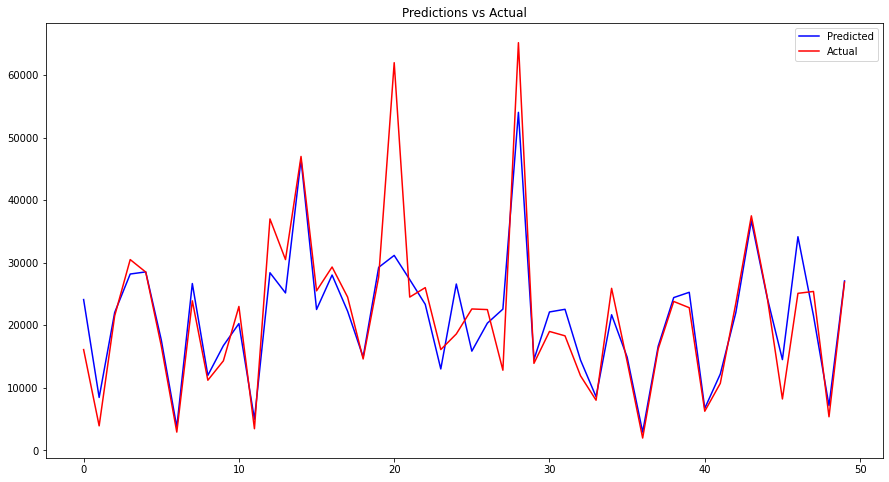

In [59]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [54]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.13325220764822018
Accuracy:  0.8667477923517798


#### Binary Encoding

In [55]:
df_new = remove_duplicates(df)
df_new = remove_listing_expired(df_new)
df_new = convert_condition(df_new)
df_new = remove_condition(df_new)

df_new = apply_encoding(df_new, ['color', 'brand', 'model', 'country', 'state'])
df_new.head()

2479it [00:00, 14251.11it/s]


,title_status,price,brand_0,brand_1,brand_2,brand_3,brand_4,model_0,model_1,model_2,...,color_5,state_0,state_1,state_2,state_3,state_4,state_5,country_0,country_1,condition_new
0,1,6300,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,1,14400
1,1,2899,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,8640
2,1,5350,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,2880
3,1,25000,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1320
4,1,27700,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1320


In [56]:
df_new_train, df_new_test = train_test_split(df_new, test_size = .30, random_state=1)

In [57]:
print(df_new_train.shape, df_new_test.shape)

(1735, 31) (744, 31)


In [58]:
df_new_train = remove_outlier(df_new_train, 'mileage')
df_new_test = remove_outlier(df_new_test, 'mileage')

In [59]:
df_new_train = remove_outlier(df_new_train, 'year')
df_new_test = remove_outlier(df_new_test, 'year')

In [60]:
print(df_new_train.shape, df_new_test.shape)

(1618, 31) (698, 31)


In [61]:
x_train = df_new_train.copy()
x_train = x_train.drop(columns = ['price'])
y_train = df_new_train['price']

In [62]:
x_test = df_new_test.copy()
x_test = x_test.drop(columns = ['price'])
y_test = df_new_test['price']

In [63]:
# define model
model = XGBRegressor(learning_rate = 0.01, n_estimators = 1000, max_depth = 10)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [64]:
y_hat = model.predict(x_test)

In [65]:
y_test_arr = y_test.to_numpy()

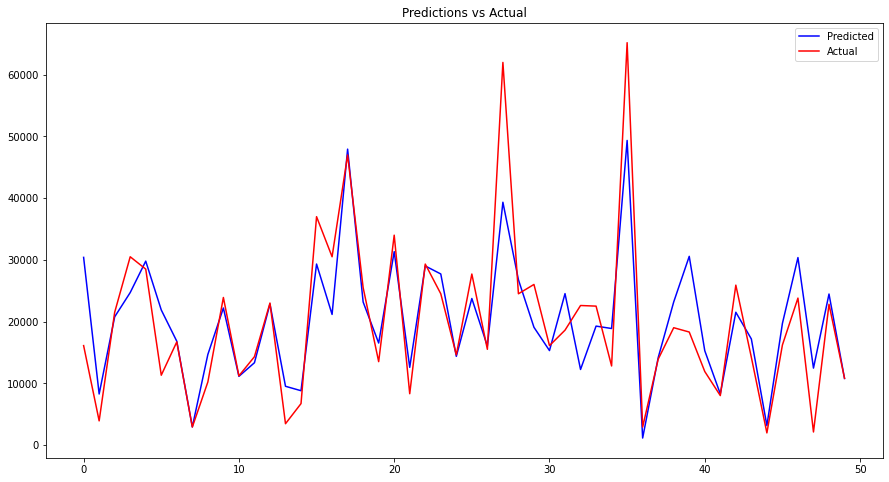

In [66]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [67]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.1461052984258569
Accuracy:  0.8538947015741432


#### One hot encoding with k fold removed outliers

In [68]:
df_new = remove_duplicates(df)
df_new = remove_listing_expired(df_new)
df_new = convert_condition(df_new)
df_new = remove_condition(df_new)
df_new = create_dummy_df(df_new,['brand', 'model', 'title_status', 'color', 'state', 'country',],dummy_na=False)
df_new.head()

2479it [00:00, 14074.98it/s]


,price,year,mileage,condition_new,brand_audi,brand_bmw,brand_buick,brand_cadillac,brand_chevrolet,brand_chrysler,...,state_tennessee,state_texas,state_utah,state_vermont,state_virginia,state_washington,state_west virginia,state_wisconsin,state_wyoming,country_ usa
0,6300,2008,274117.0,14400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2899,2011,190552.0,8640,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,5350,2018,39590.0,2880,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,25000,2014,64146.0,1320,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,27700,2018,6654.0,1320,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [69]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)
i = 1
for train_index, test_index in kf.split(df_new):
  print('\n{} of kfold {}'.format(i,kf.n_splits))

  df_new_train, df_new_test = df_new.iloc[train_index], df_new.iloc[test_index]

  df_new_train = remove_outlier(df_new_train, 'condition_new')
  df_new_test = remove_outlier(df_new_test, 'condition_new')
  df_new_train = remove_outlier(df_new_train, 'mileage')
  df_new_test = remove_outlier(df_new_test, 'mileage')
  df_new_train = remove_outlier(df_new_train, 'year')
  df_new_test = remove_outlier(df_new_test, 'year')

  x_train = df_new_train.copy()
  x_train = x_train.drop(columns = ['price'])
  y_train = df_new_train['price']

  x_test = df_new_test.copy()
  x_test = x_test.drop(columns = ['price'])
  y_test = df_new_test['price']

  model_onehot = XGBRegressor(learning_rate = 0.01, n_estimators = 1000, max_depth = 10)
  model_onehot.fit(x_train, y_train)
  # print (model.best_params_)
  y_hat = model_onehot.predict(x_test)
  mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
  acc = 1-mdape
  print("Median Absolute Percentage Error: ",mdape)
  print("Accuracy: ", acc)
  i+=1


1 of kfold 10


KeyboardInterrupt: 

In [ ]:
kfGridSearch = KFold(n_splits=10,random_state=1,shuffle=True)
i = 1
for train_index, test_index in kfGridSearch.split(df_new):
  print('\n{} of kfold {}'.format(i,kf.n_splits))
  df_new_train, df_new_test = df_new.iloc[train_index], df_new.iloc[test_index]

  df_new_train = remove_outlier(df_new_train, 'condition_new')
  df_new_test = remove_outlier(df_new_test, 'condition_new')
  df_new_train = remove_outlier(df_new_train, 'mileage')
  df_new_test = remove_outlier(df_new_test, 'mileage')
  df_new_train = remove_outlier(df_new_train, 'year')
  df_new_test = remove_outlier(df_new_test, 'year')

  x_train = df_new_train.copy()
  x_train = x_train.drop(columns = ['price'])
  y_train = df_new_train['price']

  x_test = df_new_test.copy()
  x_test = x_test.drop(columns = ['price'])
  y_test = df_new_test['price']

  xgb1 = XGBRegressor()
  parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.5], #so called `eta` value
                'n_estimators': [1000, 750, 500, 250],
                'max_depth': [10]}

  xgb_grid_onehot = GridSearchCV(xgb1, parameters, cv = 2, n_jobs = 5, verbose=True)

  xgb_grid_onehot.fit(x_train, y_train)
  y_hat = xgb_grid_onehot.predict(x_test)
  mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
  acc = 1-mdape
  print("Median Absolute Percentage Error: ",mdape)
  print("Accuracy: ", acc)
  i+=1
  print("Best parameters: ", xgb_grid_onehot.best_params_)


1 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[06:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.10680417323179271
Accuracy:  0.8931958267682073
Best parameters:  {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

2 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[06:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.11472085513032305
Accuracy:  0.885279144869677
Best parameters:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250}

3 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[06:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.114176015625
Accuracy:  0.

#### Binary encoding with k fold removed outliers

In [ ]:
df_new = remove_duplicates(df)
df_new = remove_listing_expired(df_new)
df_new = convert_condition(df_new)
df_new = remove_condition(df_new)
df_new = apply_encoding(df_new, ['color', 'brand', 'model', 'country', 'state'])
df_new.head()

2479it [00:00, 17380.42it/s]


,title_status,price,brand_0,brand_1,brand_2,brand_3,brand_4,model_0,model_1,model_2,...,color_5,state_0,state_1,state_2,state_3,state_4,state_5,country_0,country_1,condition_new
0,1,6300,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,1,14400
1,1,2899,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,8640
2,1,5350,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,2880
3,1,25000,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1320
4,1,27700,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1320


In [ ]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)
i = 1
for train_index, test_index in kf.split(df_new):
  print('\n{} of kfold {}'.format(i,kf.n_splits))

  df_new_train, df_new_test = df_new.iloc[train_index], df_new.iloc[test_index]

  df_new_train = remove_outlier(df_new_train, 'condition_new')
  df_new_test = remove_outlier(df_new_test, 'condition_new')
  df_new_train = remove_outlier(df_new_train, 'mileage')
  df_new_test = remove_outlier(df_new_test, 'mileage')
  df_new_train = remove_outlier(df_new_train, 'year')
  df_new_test = remove_outlier(df_new_test, 'year')

  x_train = df_new_train.copy()
  x_train = x_train.drop(columns = ['price'])
  y_train = df_new_train['price']

  x_test = df_new_test.copy()
  x_test = x_test.drop(columns = ['price'])
  y_test = df_new_test['price']

  model_onehot = XGBRegressor(learning_rate = 0.01, n_estimators = 1000, max_depth = 10)
  model_onehot.fit(x_train, y_train)
  # print (model.best_params_)
  y_hat = model_onehot.predict(x_test)
  mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
  acc = 1-mdape
  print("Median Absolute Percentage Error: ",mdape)
  print("Accuracy: ", acc)
  i+=1


1 of kfold 10
[06:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.12913622250145687
Accuracy:  0.8708637774985432

2 of kfold 10
[06:56:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.14222030424735915
Accuracy:  0.8577796957526409

3 of kfold 10
[06:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.13584742437214611
Accuracy:  0.8641525756278539

4 of kfold 10
[06:57:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.17970464265187736
Accuracy:  0.8202953573481226

5 of kfold 10
[06:57:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linea

In [ ]:
kfGridSearch = KFold(n_splits=10,random_state=1,shuffle=True)
i = 1
for train_index, test_index in kfGridSearch.split(df_new):
  print('\n{} of kfold {}'.format(i,kf.n_splits))
  df_new_train, df_new_test = df_new.iloc[train_index], df_new.iloc[test_index]

  df_new_train = remove_outlier(df_new_train, 'condition_new')
  df_new_test = remove_outlier(df_new_test, 'condition_new')
  df_new_train = remove_outlier(df_new_train, 'mileage')
  df_new_test = remove_outlier(df_new_test, 'mileage')
  df_new_train = remove_outlier(df_new_train, 'year')
  df_new_test = remove_outlier(df_new_test, 'year')

  x_train = df_new_train.copy()
  x_train = x_train.drop(columns = ['price'])
  y_train = df_new_train['price']

  x_test = df_new_test.copy()
  x_test = x_test.drop(columns = ['price'])
  y_test = df_new_test['price']

  xgb1 = XGBRegressor()
  parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.5], #so called `eta` value
                'n_estimators': [1000, 750, 500, 250],
                'max_depth': [10]}

  xgb_grid_binary = GridSearchCV(xgb1, parameters, cv = 2, n_jobs = 5, verbose=True)

  xgb_grid_binary.fit(x_train, y_train)
  y_hat = xgb_grid_binary.predict(x_test)
  mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
  acc = 1-mdape
  print("Median Absolute Percentage Error: ",mdape)
  print("Accuracy: ", acc)
  i+=1
  print("Best parameters: ", xgb_grid_binary.best_params_)


1 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[06:58:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.16910353127086114
Accuracy:  0.8308964687291389
Best parameters:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 250}

2 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[06:59:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.1494065381659836
Accuracy:  0.8505934618340164
Best parameters:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 250}

3 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[07:00:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.14997319464809383
Accurac

### Random Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [ ]:
y_hat = regressor.predict(x_test)

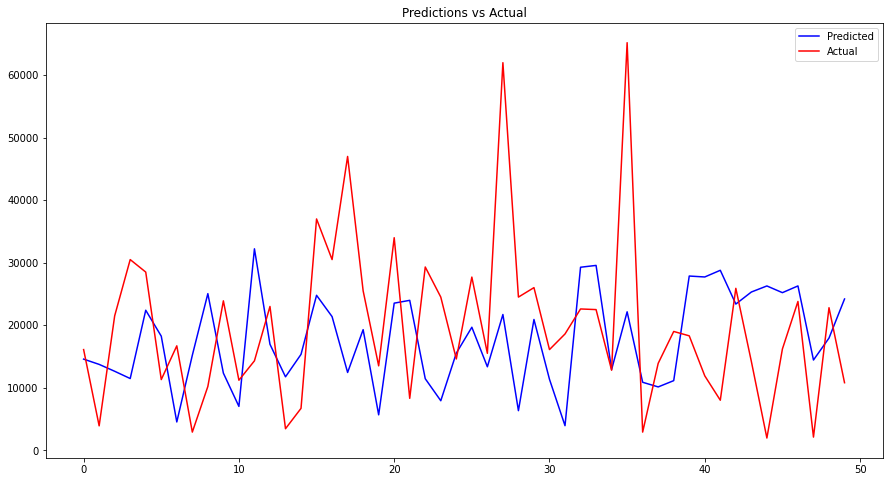

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [ ]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.1079365033467202
Accuracy:  0.8920634966532798


### Decision Tree

In [ ]:
regressor = DecisionTreeRegressor()
regressor.fit(x_train, y_train)

DecisionTreeRegressor()

In [ ]:
y_hat = regressor.predict(x_test)

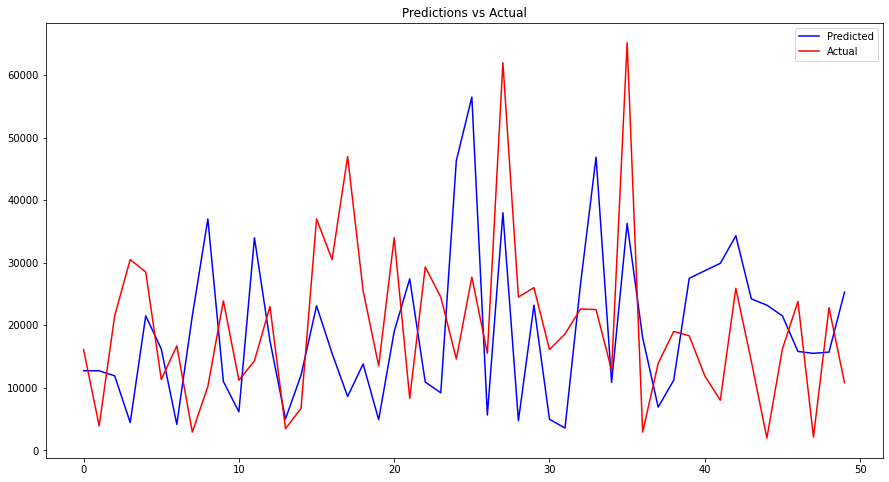

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [ ]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.12084551469456839
Accuracy:  0.8791544853054316


### ExtraTreesRegressor

In [ ]:
regressor = ExtraTreesRegressor()
regressor.fit(x_train, y_train)

ExtraTreesRegressor()

In [ ]:
y_hat = regressor.predict(x_test)

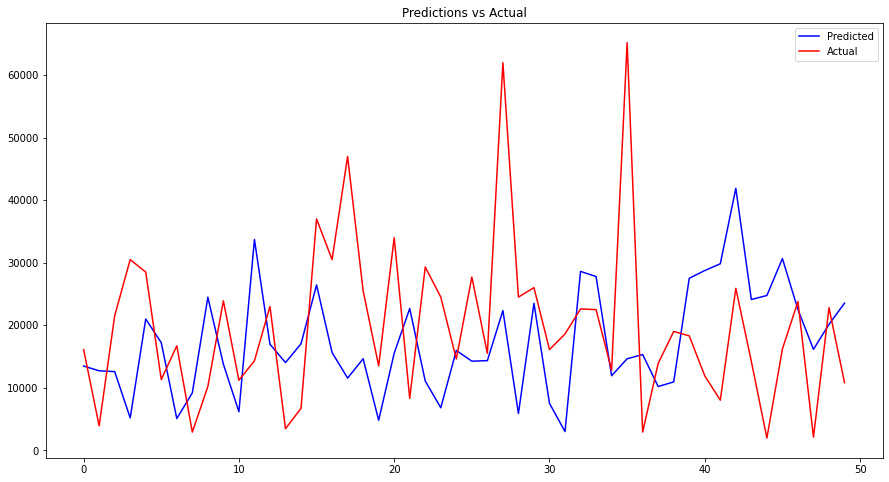

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [ ]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.10307386491981026
Accuracy:  0.8969261350801897


### AdaBoost

In [ ]:
regressor = AdaBoostRegressor()
regressor.fit(x_train, y_train)

AdaBoostRegressor()

In [ ]:
y_hat = regressor.predict(x_test)

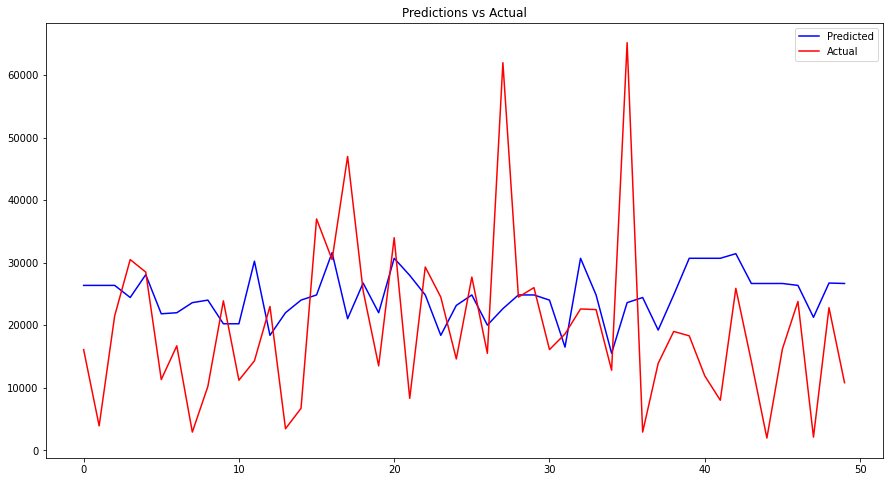

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [ ]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.3310198140510656
Accuracy:  0.6689801859489344


### Script to run all regressors

[07:14:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Accuracy for  XGBRegressor
0.6689801859489344


Accuracy for  RandomForestRegressor
0.6689801859489344


Accuracy for  DecisionTreeRegressor
0.6689801859489344


Accuracy for  ExtraTreesRegressor
0.6689801859489344


Accuracy for  AdaBoostRegressor
0.6689801859489344


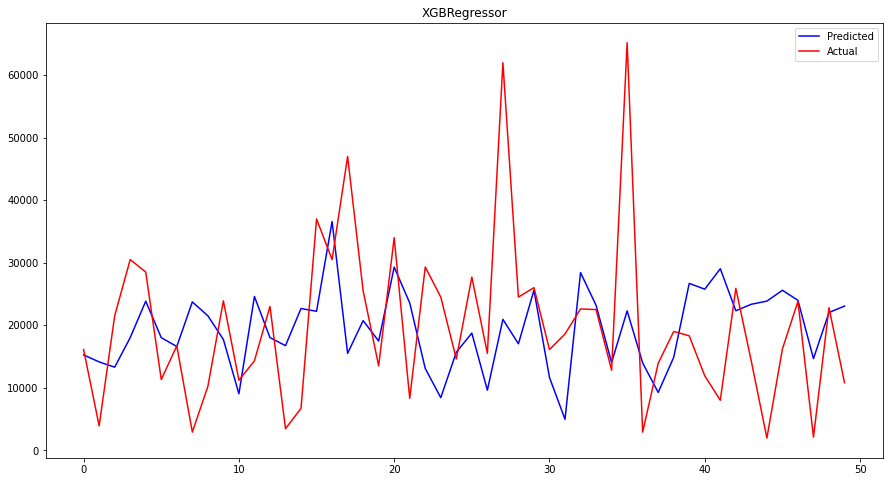

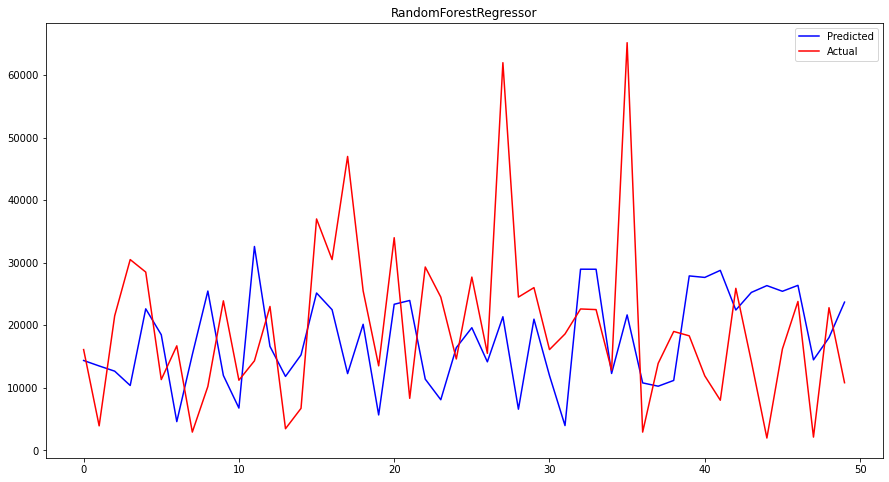

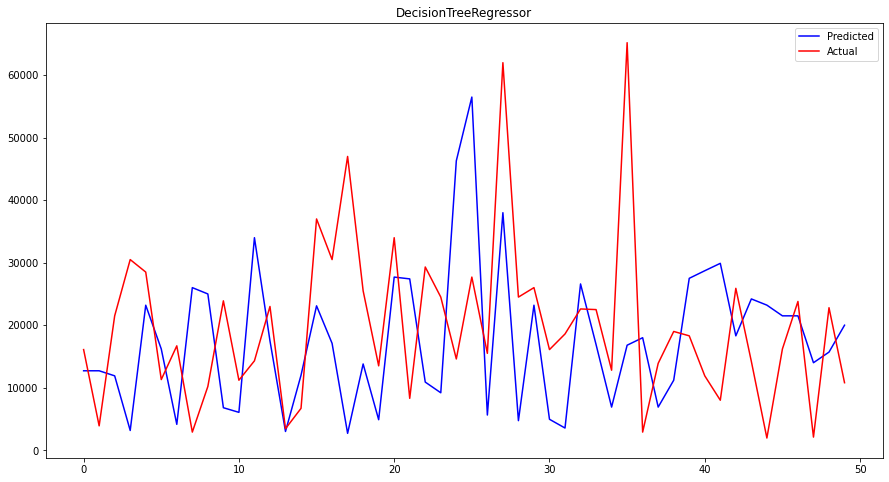

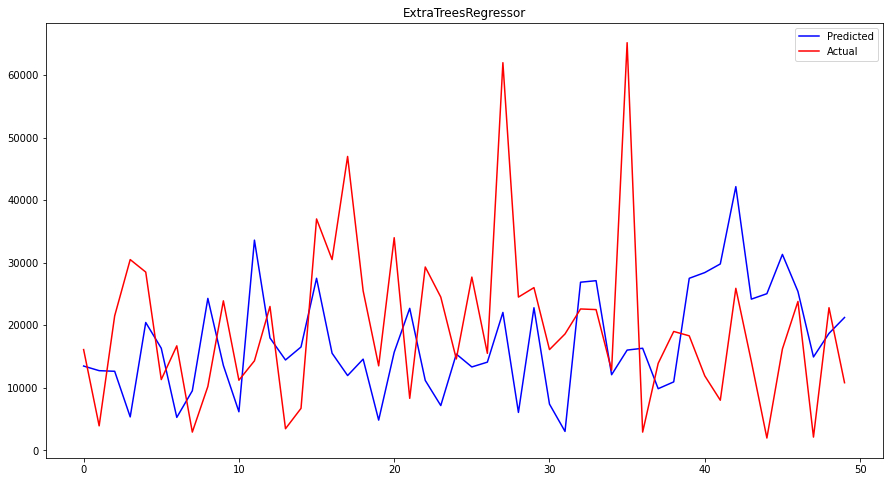

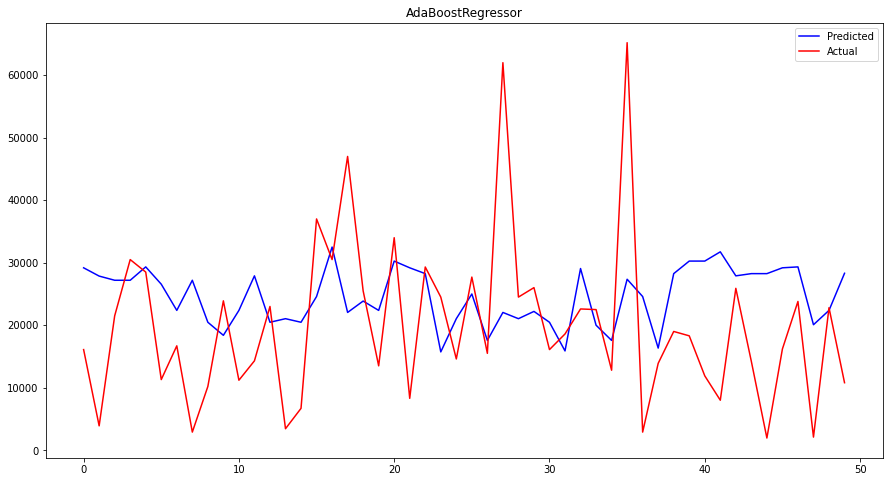

In [ ]:
regressors = ['XGBRegressor', 'RandomForestRegressor', 'DecisionTreeRegressor', 'ExtraTreesRegressor', 'AdaBoostRegressor']

for reg in regressors:
  if reg == 'XGBRegressor':
    regressor = XGBRegressor()
  if reg == 'RandomForestRegressor':
    regressor = RandomForestRegressor(n_estimators=100, random_state=0)
  if reg == 'DecisionTreeRegressor':
    regressor = DecisionTreeRegressor()
  if reg == 'ExtraTreesRegressor':
    regressor = ExtraTreesRegressor()
  if reg == 'AdaBoostRegressor':
    regressor = AdaBoostRegressor()

  regressor = TransformedTargetRegressor(regressor=regressor, transformer=MinMaxScaler())
  regressor.fit(x_train, y_train)
  y_pred = regressor.predict(x_test)

  plt.figure(figsize=(15, 8))
  plt.plot(y_pred[0:50], label='Predicted', color="blue")
  plt.plot(y_test_arr[0:50], label='Actual', color="red")
  plt.title(reg)
  plt.legend()

  print("\n")
  print("Accuracy for ", reg)
  
  mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
  acc = 1-mdape

  print(acc)